In [ ]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.lines import Line2D

rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size": 18, "weight": "bold"})
rc("text", usetex=True)

In [ ]:
slurm_output_path = "../../../LABS/EEXT/results/rmse_tables"
files = glob.glob(slurm_output_path + "/*")
extrapolation_predictions = glob.glob(slurm_output_path + "/extrapolation*")

In [3]:
pred_dfs = []
for file in extrapolation_predictions:
    df = pd.read_csv(file)
    pred_dfs.append(df)

all_extrapolation_predictions = pd.concat(pred_dfs)
print("Found", len(all_extrapolation_predictions), "extrapolation predictions")

Found 11327 extrapolation predictions


In [4]:
def get_metrics(n_loo: int, df = all_extrapolation_predictions):
    metrics = {
        "emax": [],
        "rmse_eb": [],
        "rmse_rch": [],
        "mape_eb": [],
        "mape_rch": [],
    }
    _df = df[df["N"] == n_loo]
    emaxs = _df["emax"].unique()
    for emax in emaxs:
        emax_df = _df[_df["emax"] == emax]
        metrics["emax"].append(emax)
        preds_eb = emax_df["eb_pred"].values
        preds_rch = emax_df["r_pred"].values
        true_eb = emax_df["Energy bra"].values
        true_rch = emax_df["Rch"].values
        metrics["rmse_eb"].append(np.sqrt(np.mean((preds_eb - true_eb) ** 2)))
        metrics["rmse_rch"].append(np.sqrt(np.mean((preds_rch - true_rch) ** 2)))
        metrics["mape_eb"].append(np.mean(np.abs((preds_eb - true_eb) / true_eb)) * 100)
        metrics["mape_rch"].append(np.mean(np.abs((preds_rch - true_rch) / true_rch)) * 100)
    return pd.DataFrame(metrics)

all_ns = all_extrapolation_predictions["N"].unique()
all_metrics_df = []
for n in sorted(all_ns):
    metrics = get_metrics(n)
    metrics["N"] = [n] * len(metrics)
    all_metrics_df.append(metrics)
all_metrics_df = pd.concat(all_metrics_df)

AttributeError: 'Axes' object has no attribute 'get_xtick4abels'

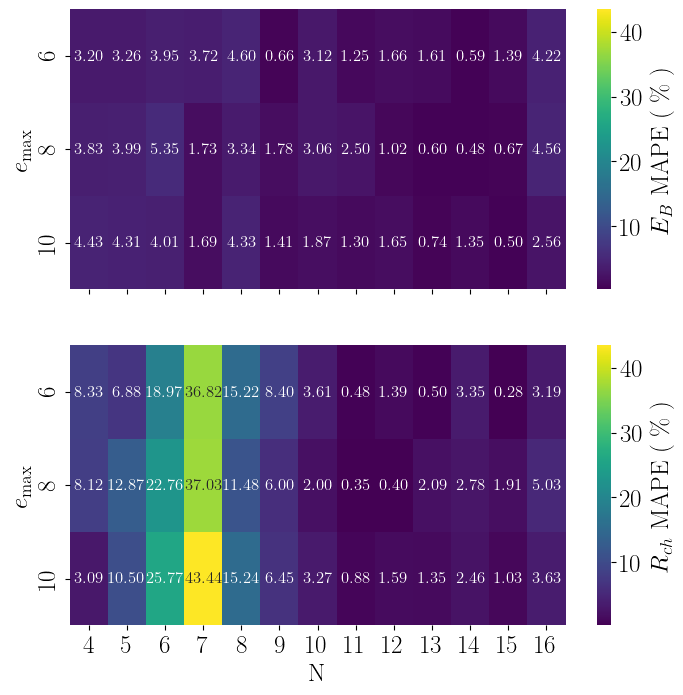

In [33]:
pivot_df = all_metrics_df.pivot(index='emax', columns='N', values='mape_eb')
pivot_df_radii = all_metrics_df.pivot(index='emax', columns='N', values='mape_rch')

vmin = min(pivot_df.min().min(), pivot_df_radii.min().min())
vmax = max(pivot_df.max().max(), pivot_df_radii.max().max())

fig, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

im1 = sns.heatmap(
    pivot_df,
    ax=axs[0],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    annot_kws={"size": 12, "weight": "bold"},
    cbar_kws={'label': r'$E_B$ MAPE' + " ( \% )"}
)
axs[0].set_ylabel("$e_{\max}$", fontsize=18, fontweight="bold")
axs[0].set_xlabel("")
axs[0].tick_params(labelsize=18)
for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontweight("bold")

im2 = sns.heatmap(
    pivot_df_radii,
    ax=axs[1],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    annot_kws={"size": 12, "weight": "bold"},
    cbar_kws={'label': '$R_{ch}$ MAPE' + " ( \% )"}
)
axs[1].set_ylabel(r"$e_{\max}$", fontsize=18, fontweight="bold")
axs[1].set_xlabel("N", fontsize=18, fontweight="bold")
axs[1].tick_params(labelsize=18)
for label in axs[1].get_xtick4abels() + axs[1].get_yticklabels():
    label.set_fontweight("bold")

plt.subplots_adjust(hspace=1.)
plt.tight_layout()
plt.savefig("/Users/jose/Documents/Works/MIT/WIP/BANNANE/final_plots/eemax_mape_heatmap.pdf", dpi=300)

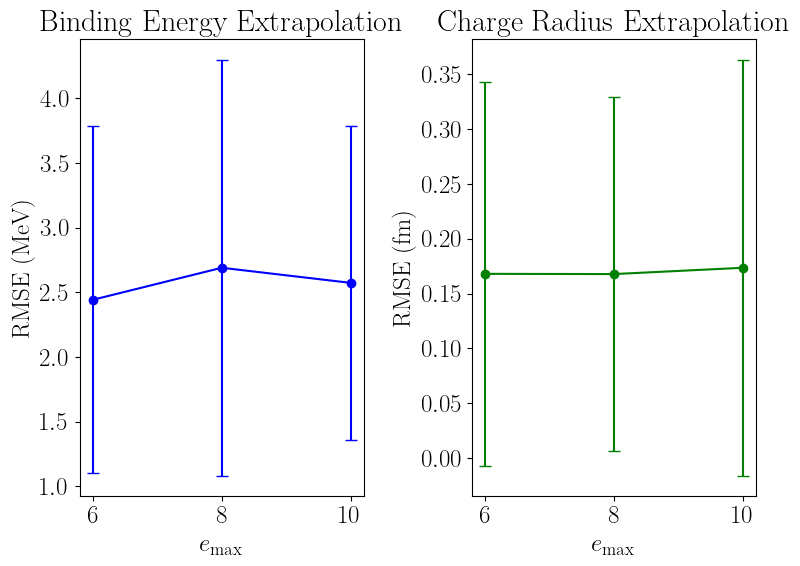

In [ ]:


metrics_df = all_metrics_df
grouped = metrics_df.groupby('emax').agg({'rmse_eb': ['mean', 'std'], 'rmse_rch': ['mean', 'std']})
grouped.columns = ['mean_rmse_eb', 'std_rmse_eb', 'mean_rmse_rch', 'std_rmse_rch']
grouped = grouped.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Panel for Binding Energy RMSE
axs[0].errorbar(grouped['emax'], grouped['mean_rmse_eb'], yerr=grouped['std_rmse_eb'],
                fmt='-o', color='blue', capsize=4)
axs[0].set_xlabel(r'$e_{\max}$')
axs[0].set_ylabel('RMSE (MeV)')
axs[0].set_title('Binding Energy Extrapolation')

# Panel for Charge Radius RMSE
axs[1].errorbar(grouped['emax'], grouped['mean_rmse_rch'], yerr=grouped['std_rmse_rch'],
                fmt='-o', color='green', capsize=4)
axs[1].set_xlabel(r'$e_{\max}$')
axs[1].set_ylabel('RMSE (fm)')
axs[1].set_title('Charge Radius Extrapolation')

plt.tight_layout()
plt.savefig("extrapolation_convergence.png", dpi=300)
plt.show()


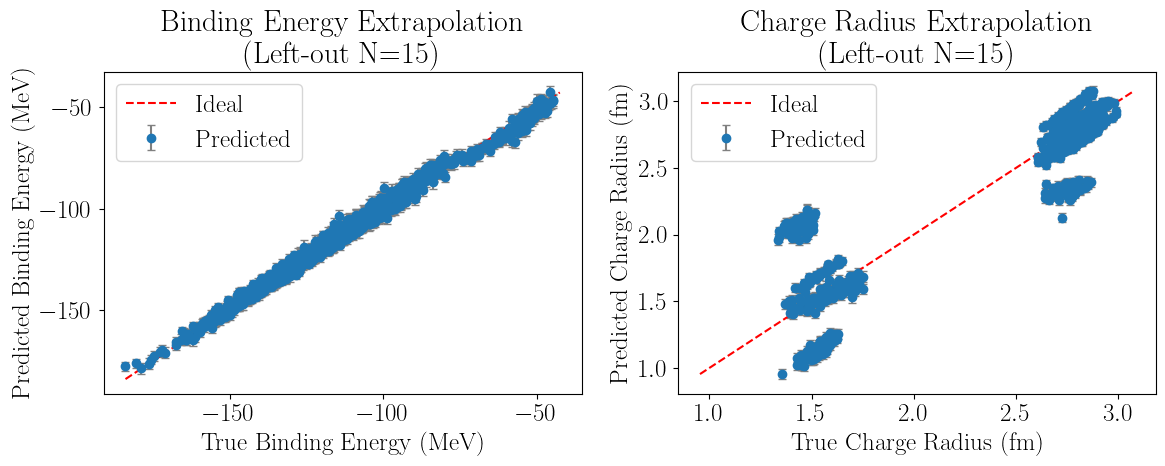

In [38]:
df = all_extrapolation_predictions.query("emax == 10")
# .query("N == 15 and emax == 10")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].errorbar(df["Energy bra"], df["eb_pred"],
                yerr=df["eb_unc"],
                fmt='o', ecolor='gray', capsize=3,
                label='Predicted')
# Plot the ideal y=x line for reference
min_eb = min(df["Energy bra"].min(), df["eb_pred"].min())
max_eb = max(df["Energy bra"].max(), df["eb_pred"].max())
axs[0].plot([min_eb, max_eb], [min_eb, max_eb], 'r--', label='Ideal')
axs[0].set_xlabel("True Binding Energy (MeV)")
axs[0].set_ylabel("Predicted Binding Energy (MeV)")
axs[0].set_title("Binding Energy Extrapolation\n(Left-out N=15)")
axs[0].legend()

# Panel (b): Charge Radius Extrapolation
# Assume the CSV contains:
#   "Rch": the true charge radius
#   "r_pred": the predicted charge radius from BANNANE
#   "r_unc": the 1σ uncertainty for radii
axs[1].errorbar(df["Rch"], df["r_pred"],
                yerr=df["r_unc"],
                fmt='o', ecolor='gray', capsize=3,
                label='Predicted')
min_r = min(df["Rch"].min(), df["r_pred"].min())
max_r = max(df["Rch"].max(), df["r_pred"].max())
axs[1].plot([min_r, max_r], [min_r, max_r], 'r--', label='Ideal')
axs[1].set_xlabel("True Charge Radius (fm)")
axs[1].set_ylabel("Predicted Charge Radius (fm)")
axs[1].set_title("Charge Radius Extrapolation\n(Left-out N=15)")
axs[1].legend()

plt.tight_layout()

# Save the figure (300 dpi is suitable for publication)
plt.savefig("extrapolation_figure.png", dpi=300)
plt.show()

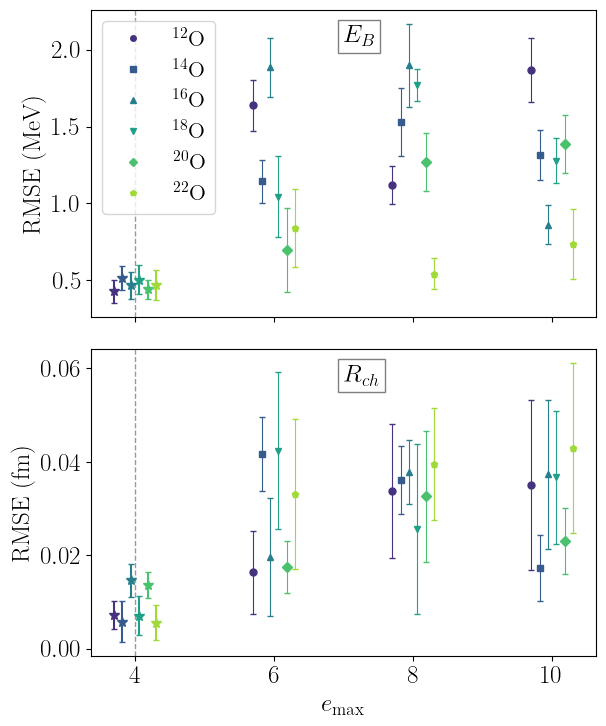

In [ ]:
nuclei_sample = range(4, 16, 2)  # Example neutron numbers (N)
emax_levels = [4, 6, 8, 10]      # Fidelity levels; training is done at e_max = 4

data = []
for n in nuclei_sample:
    for e in emax_levels:
        if e == 4:
            data.append({
                'N': n,
                'emax': e,
                'rmse_eb': np.random.uniform(0.4, 0.8),     # Binding energy RMSE (MeV)
                'std_total_eb': np.random.uniform(0.05, 0.1),
                'rmse_rch': np.random.uniform(0.005, 0.015),  # Charge radius RMSE (fm)
                'std_total_rch': np.random.uniform(0.002, 0.005)
            })
        else:
            data.append({
                'N': n,
                'emax': e,
                'rmse_eb': np.random.uniform(0.5, 2.0),
                'std_total_eb': np.random.uniform(0.1, 0.3),
                'rmse_rch': np.random.uniform(0.01, 0.05),
                'std_total_rch': np.random.uniform(0.005, 0.02)
            })

metrics_df = pd.DataFrame(data)

nuclei = sorted(metrics_df['N'].unique())
num_nuclei = len(nuclei)
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'X', 'H', 'P']
if num_nuclei > len(markers):
    markers = markers * ((num_nuclei // len(markers)) + 1)
colors = sns.color_palette("viridis", num_nuclei)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

x_offsets = np.linspace(-0.3, 0.3, num_nuclei)

for i, n in enumerate(nuclei):
    df_n = metrics_df[metrics_df['N'] == n].sort_values(by='emax')
    df_baseline = df_n[df_n['emax'] == 4]
    df_extrap = df_n[df_n['emax'] > 4]

    emax_baseline = df_baseline['emax'] + x_offsets[i]
    emax_extrap = df_extrap['emax'] + x_offsets[i]

    axs[0].errorbar(emax_baseline, df_baseline['rmse_eb'],
                    yerr=df_baseline['std_total_eb'],
                    fmt='*', color=colors[i],
                    capsize=2, markersize=7, alpha=1., label=f'$^{{{n+8}}}$O')

    axs[0].errorbar(emax_extrap, df_extrap['rmse_eb'],
                    yerr=df_extrap['std_total_eb'],
                    marker=markers[i], linestyle='None', alpha=1.,
                    color=colors[i], capsize=2, markersize=5, linewidth=0.8)

    axs[1].errorbar(emax_baseline, df_baseline['rmse_rch'],
                    yerr=df_baseline['std_total_rch'],
                    fmt='*', color=colors[i],
                    capsize=2, markersize=7, alpha=1.)

    axs[1].errorbar(emax_extrap, df_extrap['rmse_rch'],
                    yerr=df_extrap['std_total_rch'],
                    marker=markers[i], linestyle='None', alpha=1.,
                    color=colors[i], capsize=2, markersize=5, linewidth=0.8)

plt.subplots_adjust(hspace=0.25)

for ax in axs:
    ax.axvline(x=4, color='gray', linestyle='--', linewidth=1, alpha=0.8)

axs[0].set_ylabel('RMSE (MeV)', fontsize=18)
axs[1].set_ylabel('RMSE (fm)', fontsize=18)
axs[1].set_xlabel(r'$e_{\max}$', fontsize=18)

axs[0].text(0.5, 0.95, r'$E_B$', transform=axs[0].transAxes,
            fontsize=18, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5))
axs[1].text(0.5, 0.95, r'$R_{ch}$',
            transform=axs[1].transAxes, fontsize=18, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5))

legend_elements = []
for i, n in enumerate(nuclei):
    legend_elements.append(Line2D([0], [0], marker=markers[i], color=colors[i],
                                  linestyle='None', markersize=4, linewidth=0.8,
                                    label=f'$^{{{n+8}}}$O'))

axs[0].legend(handles=legend_elements, loc='best', ncol=1, fontsize=16)
plt.xticks(emax_levels)
plt.tight_layout(rect=[0.2, 0, 1, 0.95])
plt.savefig("extrapolation_convergence.pdf", bbox_inches='tight')